### Connecting to the PostgreSQL Database

In [1]:
# Connect to local postgresql database
import pandas as pd
import numpy as np
import psycopg2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from dotenv import load_dotenv
load_dotenv()

pgconn = psycopg2.connect(
    host="localhost",
    user="postgres",
    password=os.getenv('PASSWORD'))

pgcursor = pgconn.cursor()

from sqlalchemy import create_engine
password=os.getenv('PASSWORD')
engine = create_engine('postgresql+psycopg2://postgres:' + password + '@localhost/kinodb')

### Querying the Database

In [ ]:
# Query Example using Python for-loop and f-strings to send multiple queries
years = [2010, 2011, 2012, 2013, 2014]
counts = []

for year in years:
    count = pd.read_sql_query(f"""SELECT COUNT(*) FROM public.films WHERE year = {year}""", engine)
    counts.append({'years': year, 'count': count['count'][0]})

df = pd.DataFrame.from_records(counts)

In [ ]:
# Simple Data Visualization using Matplotlib/Seaborn of queried data
labels = list(df['years'])
data = list(df['count'])
plt.pie(data, labels = labels, colors=sns.color_palette('pastel')[0:5], autopct='%.0f%%')
plt.show()

# Query Examples Through Pandas

### Directors Who Played a Role in their films

In [ ]:
# Alright, so here's a query that shows every film in which the Director also played a role as an actor
df = pd.read_sql_query(f"""
    SELECT DISTINCT film_name, director, actor 
    FROM public.films
    INNER JOIN actors ON actorid = id
    WHERE REPLACE(LOWER(director), ' ', '-') = actor"""
                       , engine)

display(df)
print(f'There are {len(df)} results!')

### Directors Who Played A Role in their Film (with ratings)

In [ ]:
# Let's sort out the films that actually have ratings attached to them (more mainstream titles) and sort by descending rating
df = pd.read_sql_query(f"""

    SELECT DISTINCT film_name, director, actor, rating FROM public.films
    INNER JOIN actors ON actorid = id
    WHERE REPLACE(LOWER(director), ' ', '-') = actor and rating > 0
    ORDER BY rating DESC
    
    """, engine)
display(df)

print(f'Now there are {len(df)} results!')

### Quentin Tarantino Examples

In [ ]:
# That's pretty neat. Now we look at a specific Director...how many films has Quentin Tarantino casted himself in?
df_casted = pd.read_sql_query(f"""

    SELECT * FROM public.films
    INNER JOIN actors ON actorid = id
    WHERE REPLACE(LOWER(director), ' ', '-') = actor and rating > 0 and director = 'Quentin Tarantino'
    
    """, engine)
display(df_casted)
#print(f'Quentin Tarantino has casted himself in {df_casted["count"][0]} movies that he also directed.')

In [ ]:
# But, out of how many total films directed has he also starred in?
df_total = pd.read_sql_query(f"""
    SELECT COUNT(*) FROM public.films
    WHERE director = 'Quentin Tarantino'"""
                       , engine)

display(df_total)
print(f'Quentin Tarantino has directed a total of {df_total["count"][0]} movies.')

In [ ]:
# So in total...
df_comp = pd.read_sql_query(f"""SELECT ROUND({df_casted["count"][0]/df_total["count"][0]}, 3)*100""", engine)

print(f'Quentin Tarantino has played an acting role in {df_casted["count"][0]} out of his {df_total["count"][0]} total directed films ({df_comp["?column?"][0]}%).')

### Top 10 Director/Actor Films

In [ ]:
# We can also look at the top 10 director/actor films overall
df = pd.read_sql_query(f"""

    SELECT director, count(director) FROM public.films
    INNER JOIN actors ON actorid = id
    WHERE REPLACE(LOWER(director), ' ', '-') = actor and rating > 0
    GROUP BY director
    ORDER BY COUNT(director) DESC
    LIMIT 10
    
    """, engine)
display(df)

In [ ]:
# And with Seaborn/matplotlib...
directors = list(df['director'])
num_films = list(df['count'])
figure = sns.barplot(x=directors, y=num_films)
figure.set_xticklabels(figure.get_xticklabels(), rotation=45, horizontalalignment='right')
figure.set_title('Top 10 Directors Who Also Played Roles in Their Films')
figure.set_ylabel('Number of Films')
plt.show()

### Action Movies in the Last 10 Years

In [ ]:
df = pd.read_sql_query(f"""
    SELECT year, count(year) FROM public.films
    INNER JOIN genres ON genreid = id
    WHERE genre = 'action' and country = 'usa' and rating > 0 and year BETWEEN 2010 and 2020
    GROUP BY year"""
                       , engine)

display(df)

In [ ]:
# Plot action movie data
years = list(df['year'])
num_films = list(df['count'])
figure = sns.barplot(x=years, y=num_films)
figure.set_title('Action Movies Released in the U.S. from 2010 to 2020')
figure.set_ylabel('Number of Films Released')
plt.show()

### Animated Movies in the Last 20 Years + Linear Regression

In [2]:
df = pd.read_sql_query(f"""
    SELECT year, count(year) FROM public.films
    INNER JOIN genres ON genreid = id
    WHERE genre = 'animation' and country = 'usa' and rating > 0 and year BETWEEN 2000 and 2020
    GROUP BY year
    """, engine)
display(df)

,year,count
0,2000,33
1,2001,39
2,2002,40
3,2003,41
4,2004,54
5,2005,62
6,2006,60
7,2007,61
8,2008,64
9,2009,63


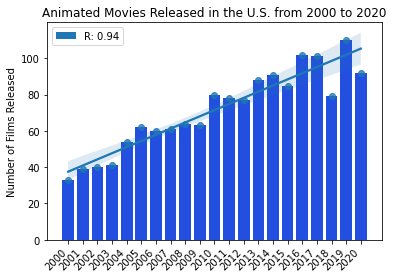

In [3]:
# Plot animated movie data with trendline
years = list(df['year'])
num_films = list(df['count'])
figure = sns.barplot(x=years, y=num_films, palette=sns.color_palette('bright')[0:1])
figure.set_title('Animated Movies Released in the U.S. from 2000 to 2020')
figure.set_xticklabels(figure.get_xticklabels(), rotation=45, horizontalalignment='right')
figure.set_ylabel('Number of Films Released')

for c in figure.patches:
    c.set_zorder(0)
sns.regplot(x=np.arange(0, len(years)), y=num_films, ax=figure)

from scipy.stats import linregress
rvalue = mpatches.Patch(label=f'R: {linregress(years,num_films)[2].__round__(2)}')
plt.legend(handles=[rvalue])
plt.show()

### Action Movies in the Last 10 Years Compared to Total Amount of Movies Released

In [ ]:
df = pd.read_sql_query(f"""
    SELECT year, count(year) FROM public.films
    INNER JOIN genres ON genreid = id
    WHERE genre = 'action' and country = 'usa' and rating > 0 and year BETWEEN 2010 and 2020
    GROUP BY year
    UNION ALL
    SELECT year, count(year) FROM public.films
    WHERE country = 'usa' and rating > 0 and year BETWEEN 2010 and 2020
    GROUP BY year
    """, engine)
display(df)

In [ ]:
fig_df = pd.DataFrame({"Action Films": list(df['count'][0:11]), 
                       "All Films": list(df['count'][11:22]),
                       "Year": list(df['year'][0:11])})
s1 = sns.barplot(x = 'Year', y = 'All Films', data = fig_df, color=sns.color_palette('bright')[0], label = 'All Films')
s2 = sns.barplot(x = 'Year', y = 'Action Films', data = fig_df, color=sns.color_palette('bright')[1], label = 'Action Films')
s1.set_title('Action Movies vs Total Movies Released from 2010 to 2020')
s1.set_ylabel('Number of Films Released')
color1 = mpatches.Patch(color=sns.color_palette('bright')[0], label='All Films')
color2 = mpatches.Patch(color=sns.color_palette('bright')[1], label='Action Films')
plt.legend(handles=[color1, color2])

### Animated Movies in the Last 10 Years Compared to Total Amount of Movies Released

In [ ]:
df = pd.read_sql_query(f"""
    SELECT year, count(year) FROM public.films
    INNER JOIN genres ON genreid = id
    WHERE genre = 'animation' and country = 'usa' and rating > 0 and year BETWEEN 2010 and 2020
    GROUP BY year
    UNION ALL
    SELECT year, count(year) FROM public.films
    WHERE country = 'usa' and rating > 0 and year BETWEEN 2010 and 2020
    GROUP BY year"""
                       , engine)

display(df)

In [ ]:
import matplotlib.patches as mpatches

fig_df = pd.DataFrame({"Animated Films": list(df['count'][0:11]), 
                       "All Films": list(df['count'][11:22]),
                       "Year": list(df['year'][0:11])})
s1 = sns.barplot(x = 'Year', y = 'All Films', data = fig_df, color=sns.color_palette('bright')[0], label = 'All Films')
s2 = sns.barplot(x = 'Year', y = 'Animated Films', data = fig_df, color=sns.color_palette('bright')[1], label = 'Action Films')
s1.set_title('Animated Movies vs Total Movies Released from 2010 to 2020')
s1.set_ylabel('Number of Films Released')
color1 = mpatches.Patch(color=sns.color_palette('bright')[0], label='All Films')
color2 = mpatches.Patch(color=sns.color_palette('bright')[1], label='Animated Films')
plt.legend(handles=[color1, color2])

### Average Ratings by Genre (MultiLine Plot)

In [ ]:
genre_list = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama',
              'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
              'science-fiction', 'thriller', 'tv-movie', 'war', 'western']
year1 = 2010
year2 = 2020
all_df = pd.DataFrame({'year': range(year1, year2+1)})
for genre in genre_list:
    query_df = pd.read_sql_query(f"""
        SELECT year, AVG(rating) FROM public.films
        INNER JOIN genres ON genreid = id
        WHERE genre = '{genre}' and country = 'usa' and rating > 0 and year BETWEEN {year1} and {year2}
        GROUP BY year"""
                           , engine)
    query_df.rename(columns = {'avg': genre}, inplace = True)
    all_df = all_df.merge(query_df, how='left', on='year')
    
display(all_df)

In [ ]:
# While this may work, the data is a mess when presented in this format on one figure
# An interactable figure where the user may choose which genres to display would be more appropriate for displaying this type of data
# I could also probably use the genre_list and the SQL data to construct this DataFrame in a loop...
data = pd.DataFrame({
    'Year': range(year1, year2+1), 
    'action': list(all_df[f'action']),
    'adventure': list(all_df[f'adventure']),
    'animation': list(all_df[f'animation']),
    'comedy': list(all_df[f'comedy']),
    'crime': list(all_df[f'crime']),
    'documentary': list(all_df[f'documentary']),
    'drama': list(all_df[f'drama']),
    'family': list(all_df[f'family']),
    'fantasy': list(all_df[f'fantasy']),
    'history': list(all_df[f'history']),
    'horror': list(all_df[f'horror']),
    'music': list(all_df[f'music']),
    'mystery': list(all_df[f'mystery']),
    'romance': list(all_df[f'romance']),
    'science-fiction': list(all_df[f'science-fiction']),
    'thriller': list(all_df[f'thriller']),
    'tv-movie': list(all_df[f'tv-movie']),
    'war': list(all_df[f'war']),
    'western': list(all_df[f'western'])})

fig = sns.lineplot(x='Year', y='value', hue='variable', data=pd.melt(data, ['Year']))
fig.set_ylabel('Average Rating')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

### Movies made in the United States but not in English

In [ ]:
df = pd.read_sql_query(f"""
    SELECT language, count(language) FROM public.films
    WHERE country = 'usa' and rating > 0 and language != 'english' and language != 'no-spoken-language'
    GROUP BY language
    ORDER BY count(language) desc"""
                       , engine)

display(df)

In [ ]:
language = list(df['language'])
num_films = list(df['count'])
figure = sns.barplot(x=language, y=num_films)
figure.set_title('Non-English Movies Made in the United States')
figure.set_xticklabels(figure.get_xticklabels(), rotation=60, horizontalalignment='right')
figure.set_ylabel('Number of Films Released')
plt.show()

# This is kinda messy, let's only take the top 20!

In [ ]:
df = pd.read_sql_query(f"""
    SELECT language, count(language) FROM public.films
    WHERE country = 'usa' and rating > 0 and language != 'english' and language != 'no-spoken-language'
    GROUP BY language
    ORDER BY count(language) desc
    LIMIT 20
    """, engine)
display(df)

In [ ]:
language = list(df['language'])
num_films = list(df['count'])
figure = sns.barplot(x=language, y=num_films)
figure.set_title('Non-English Movies Made in the United States')
figure.set_xticklabels(figure.get_xticklabels(), rotation=45, horizontalalignment='right')
figure.set_ylabel('Number of Films Released')
plt.show()

# This is much more readable now.

In [ ]:
# Closes connections to postgresql database
pgconn.close()
engine.dispose()